# Исследование пользователей сервиса аренды самокатов GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

    без подписки
      
        абонентская плата отсутствует;
        стоимость одной минуты поездки — 88 рублей;
        стоимость старта (начала поездки) — 5050 рублей;
    с подпиской Ultra
      
        абонентская плата — 199199 рублей в месяц;
        стоимость одной минуты поездки — 66 рублей;
        стоимость старта — бесплатно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
from scipy import stats as st
import numpy as np
import matplotlib

Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — users_go.csv
	
user_id - уникальный идентификатор пользователя

name - имя пользователя

age - возраст

city - город

subscription_type -	тип подписки (free, ultra)


Поездки — rides_go.csv
	
user_id - уникальный идентификатор пользователя

distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)

duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

date - дата совершения поездки


Подписки — subscriptions_go.csv
	
subscription_type - тип подписки

minute_price - стоимость одной минуты поездки по данной подписке

start_ride_price - стоимость начала поездки

subscription_fee - стоимость ежемесячного платежа

#### Шаг 1. Загрузка данных

In [ ]:
users_df = pd.read_csv('./users_go.csv')
rides_df = pd.read_csv('./rides_go.csv')
subscriptions_df = pd.read_csv('./subscriptions_go.csv')

Первые 10 строк каждой из таблиц

In [3]:
display(users_df.head(10))
display(rides_df.head(10))
display(subscriptions_df.head(10))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Инфомация о столбцах

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
subscriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


#### Шаг 2. Предобработка данных

Столбец date таблицы rides к типу даты

In [7]:
rides_df['date'] = \
pd.to_datetime(rides_df['date'], utc=False, \
               format='%Y-%m-%d')

Новый столбец с номером месяца

In [8]:
rides_df['month'] = rides_df['date'].apply(lambda x: x.month)

Проверка

In [9]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Тип изменился, новый столбец появился

Проверка наличия дупликатов

In [10]:
users_df.duplicated().sum()

31

Удаляем явные дупликаты

In [11]:
users_df = users_df.drop_duplicates()
print(users_df.duplicated().sum())

0


In [12]:
rides_df.duplicated().sum()

0

In [13]:
subscriptions_df.duplicated().sum()

0

Выводы:

1. Были загружены и просмотрены первые строки 3 датасетов - с информацией о пользователях, поездках и типах подписки.
2. Столбце date таблицы поездок был приведен к типу даты pandas
3. Был создан отдельный столбец с номером месяца по столбцу date
4. Таблицы были проверены на наличие явных дупликатов, в датафрейме пользователей был удален 31 явный дупликат.

In [15]:
rides_df['distance'] = rides_df['distance'].round(2)
rides_df['distance'].head(3)

0    4409.92
1    2617.59
2     754.16
Name: distance, dtype: float64

Визуализация распределения длительность и дальности поездок

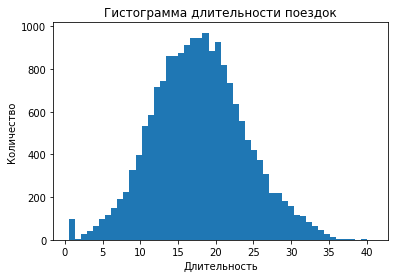

In [16]:
plt.hist(rides_df['duration'], bins=50)
plt.title('Гистограмма длительности поездок')
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.show()

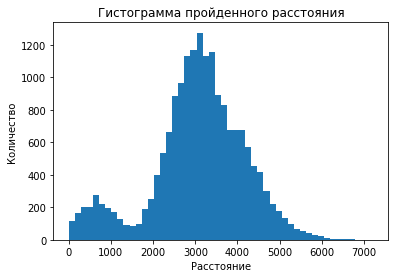

In [17]:
plt.hist(rides_df['distance'], bins=50)
plt.title('Гистограмма пройденного расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.show()

В аномальные значения можем записать только пик около нуля для длительность поездок

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов 

In [18]:
city_df = users_df.groupby(by='city').count()\
.sort_values(by='user_id', ascending=False)['user_id']
display(city_df)
city_df = city_df / city_df.sum()
display(city_df)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

city
Пятигорск         0.142764
Екатеринбург      0.132986
Ростов-на-Дону    0.129074
Краснодар         0.125815
Сочи              0.123207
Омск              0.119296
Тюмень            0.117340
Москва            0.109518
Name: user_id, dtype: float64

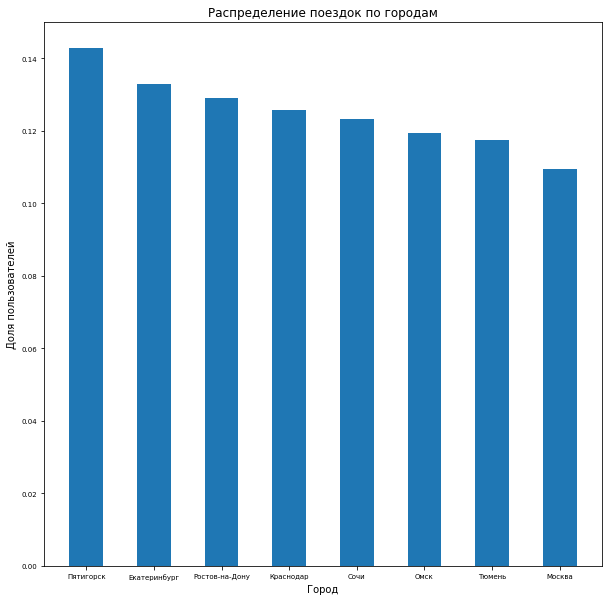

In [19]:
matplotlib.rc('xtick', labelsize=7)
matplotlib.rc('ytick', labelsize=7)
plt.figure(figsize=(10,10))
plt.bar(city_df.index, city_df, width=0.5)
plt.xlabel('Город')
plt.ylabel('Доля пользователей')
plt.title('Распределение поездок по городам')
plt.show()

Примерно равное количество пользователей из восьми городов.

##### Соотношение пользователей с подпиской и без подписки

In [21]:
subscr_df = users_df.groupby(by='subscription_type').count()\
.sort_values(by='user_id', ascending=False)['user_id']
display(subscr_df)
subscr_df = subscr_df / subscr_df.sum()
display(subscr_df)

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

subscription_type
free     0.544329
ultra    0.455671
Name: user_id, dtype: float64

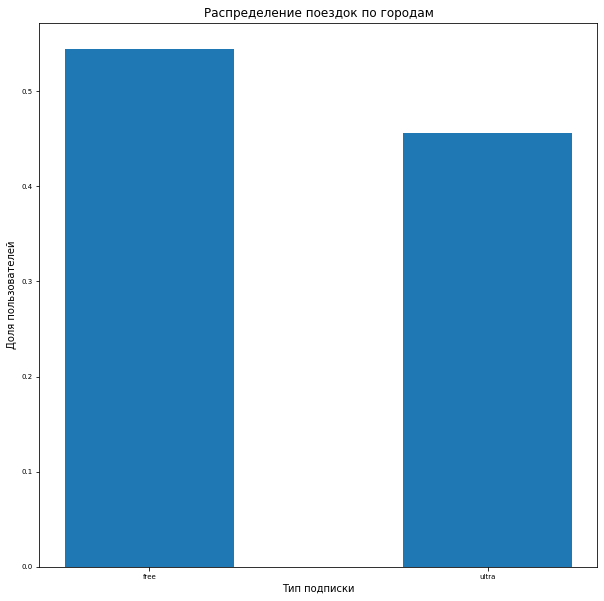

In [22]:
matplotlib.rc('xtick', labelsize=7)
matplotlib.rc('ytick', labelsize=7)
plt.figure(figsize=(10,10))
plt.bar(subscr_df.index, subscr_df, width=0.5)
plt.xlabel('Тип подписки')
plt.ylabel('Доля пользователей')
plt.title('Распределение поездок по городам')
plt.show()
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

Имеем примерно равное количество пользователей с подпиской и без нее.

Около 54% пользователей с подпиской free, остальные подпиской ultra.

##### Возраст пользователей

In [24]:
users_df['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [25]:
age_df = users_df.groupby(by='age').count()\
.sort_values(by='age', ascending=True)
display(age_df['user_id'])

age
12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: user_id, dtype: int64

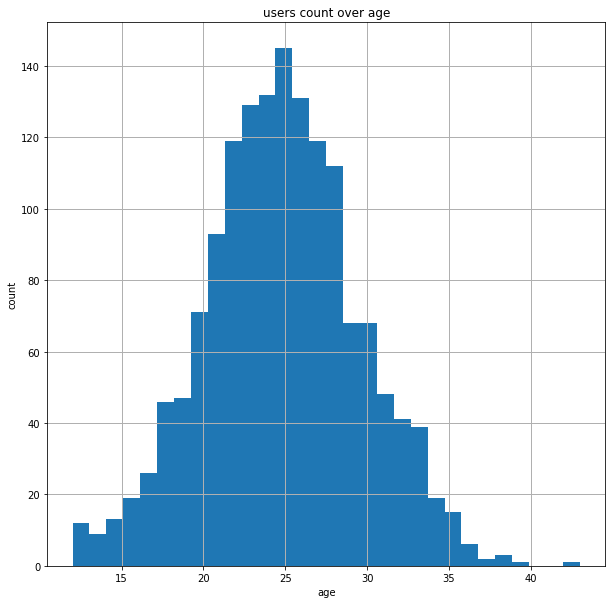

In [26]:
plt.figure(figsize=(10,10))
plt.hist(users_df['age'], bins=30)
plt.title('users count over age')
plt.xlabel('age')
plt.grid(linestyle='-', linewidth=1)
plt.ylabel('count')
plt.show()

Распределение похоже на нормальное, что вполне ожидаемо.

##### Расстояние, которое пользователь преодолел за одну поездку

In [27]:
rides_df['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

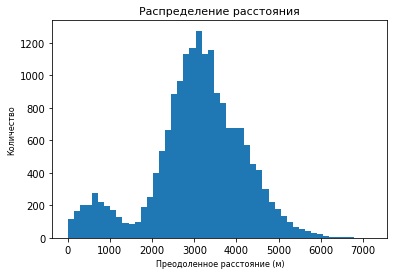

In [28]:
plt.hist(rides_df['distance'], bins=50);
plt.title('Распределение расстояния', fontsize=11)
plt.xlabel('Преодоленное расстояние (м)', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

Распределение похоже на смесь нормальных, видим 2 пика. Можем предположить, что пики отвечают в основном пользователям с разными типами подписки: пользователи с подпиской ultra могут позволить себе проехать небольшое расстояние - около 700 метров, пользователи с подпиской free, напротив, стараются брать самокаты только для езды только на большие расстояния, чтобы стоимость старта была не так ощутима.

##### Продолжительность поездок

In [29]:
rides_df['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

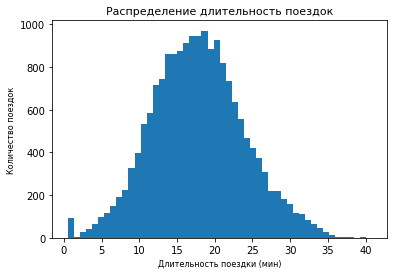

In [30]:
plt.hist(rides_df['duration'], bins=50);
plt.title('Распределение длительность поездок', fontsize=11)
plt.xlabel('Длительность поездки (мин)', fontsize=8)
plt.ylabel('Количество поездок', fontsize=8)
plt.show()

Распределение близко к нормальному, есть небольшой пик около нуля, его можем просто отфильтровать.

Короткие поездки

In [31]:
display(rides_df[rides_df['duration']<1])

,user_id,distance,duration,date,month
6531,701,4196.45,0.5,2021-08-31,8
6570,704,4830.82,0.5,2021-10-14,10
6680,712,4684.00,0.5,2021-03-04,3
6695,713,5215.64,0.5,2021-02-25,2
6768,718,5197.44,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.34,0.5,2021-01-19,1
17242,1477,6724.93,0.5,2021-01-12,1
17314,1483,4445.48,0.5,2021-03-06,3
17505,1496,5722.55,0.5,2021-02-14,2


In [32]:
display(rides_df[rides_df['duration']<1]['distance'].mean())

5113.176736842105

Выводы:
    
1. Пользователей из разных городов похожее количество
2. Пользователей без подписки немного больше, чем с подпиской ( 54% против 46%)
3. Средний возраст пользователей составляет 25 лет, при этом минимальный - 12 лет, что является нарушением законодательства или ошибкой в данных.
4. Пройденной расстояние изменяется от 1 м до 7 км, при этом гистограмма имеет 2 пика - короткие (около 700 м) и длинные (около 3 км) поездки.
5. Длительность поездок изменяется от 0.5 мин до 40 мин со средним в 15 мин, при этом некоторые из самых коротких поездок (около 30 сек) имеют расстояние в 4 км, т.е. неправильно работает подсчёт времени поездки.

#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [33]:
first_df = pd.merge(users_df, rides_df, how='right', on='user_id')
general_df = pd.merge(first_df, subscriptions_df, \
                      how='left', on='subscription_type')
display(general_df.head(20))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.89,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.02,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.12,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.69,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.69,15.041884,2021-11-22,11,6,0,199


In [34]:
print('Пользователи:', len(users_df), len(users_df.columns))
print('Поездки:', len(rides_df), len(rides_df.columns))
print('Типы подписок:', \
      len(subscriptions_df), len(subscriptions_df.columns))
print('Итоговый датафрейм:', len(general_df), len(general_df.columns))

Пользователи: 1534 5
Поездки: 18068 5
Типы подписок: 2 4
Итоговый датафрейм: 18068 12


Получили 18068 строк, как и в таблице с поездками.

Число столбцов = 5 + 5 + 4 - 2 = 12, как и ожидалось.

Проверка на пропуски:

In [35]:
display(general_df.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропуски отсутствуют

##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
    c данными о пользователях без подписки;
    с данными о пользователях с подпиской.

In [36]:
general_free_df = general_df[general_df['subscription_type'] == 'free']
general_ultra_df = general_df[general_df['subscription_type'] == 'ultra']
display(general_free_df.head())
display(general_ultra_df.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.427673,2021-02-14,2,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199


Проверка

In [37]:
display(general_free_df.groupby('subscription_type').mean())
display(general_ultra_df.groupby('subscription_type').mean())

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
subscription_type,,,,,,,,
free,1120.52723,24.893326,3045.495284,17.390909,6.522994,8.0,50.0,0.0


,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
subscription_type,,,,,,,,
ultra,348.725385,24.892615,3115.445431,18.541985,6.422308,6.0,0.0,199.0


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

Пользователи без подписки

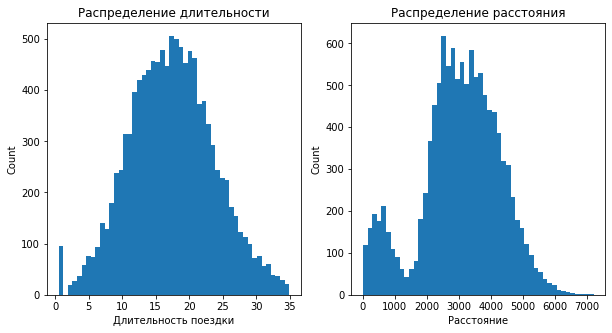

In [38]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.hist(general_free_df['duration'], bins=50)
plt.title('Распределение длительности')
plt.xlabel('Длительность поездки')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(general_free_df['distance'], bins=50)
plt.title('Распределение расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Count')

plt.show()

Пользователи с подпиской

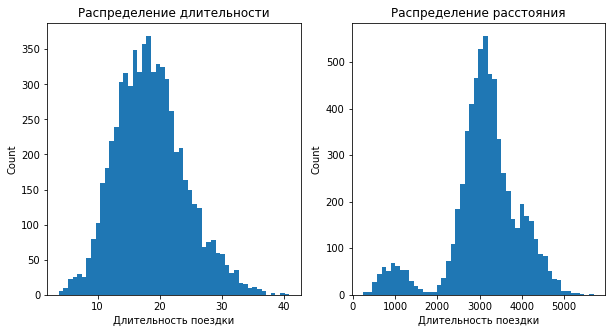

In [39]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.hist(general_ultra_df['duration'], bins=50)
plt.title('Распределение длительности')
plt.xlabel('Длительность поездки')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(general_ultra_df['distance'], bins=50)
plt.title('Распределение расстояния')
plt.xlabel('Длительность поездки')
plt.ylabel('Count')

plt.show()

В одной системе координат:

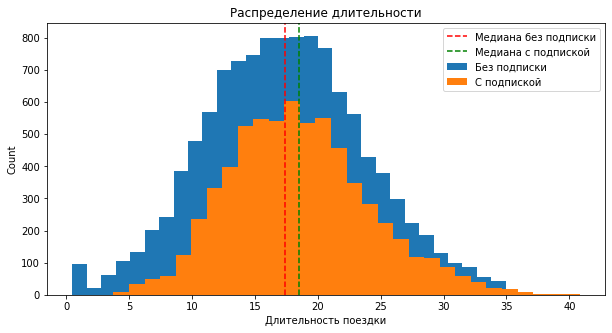

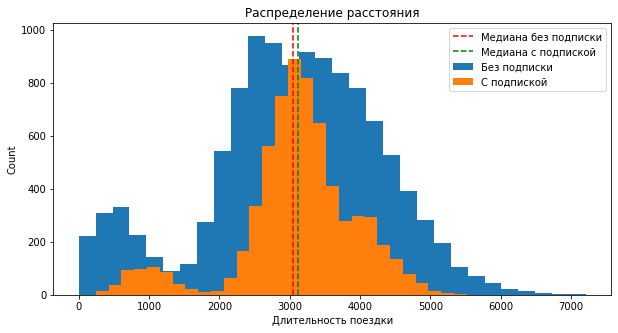

In [40]:
plt.figure(figsize=[10, 5])
plt.hist(general_free_df['duration'], bins=30, label='Без подписки')
plt.hist(general_ultra_df['duration'], bins=30, label='С подпиской')
plt.axvline(x=general_free_df['duration'].mean(), \
            color='r', linestyle='--',label='Медиана без подписки')
plt.axvline(x=general_ultra_df['duration'].mean(), \
            color='g', linestyle='--',label='Медиана с подпиской')
plt.title('Распределение длительности')
plt.xlabel('Длительность поездки')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=[10, 5])
plt.hist(general_free_df['distance'], bins=30, label='Без подписки')
plt.hist(general_ultra_df['distance'], bins=30, label='С подпиской')
plt.axvline(general_free_df['distance'].mean(), \
            color='r', linestyle='--',label='Медиана без подписки')
plt.axvline(x=general_ultra_df['distance'].mean(), \
            color='g', linestyle='--',label='Медиана с подпиской')
plt.title('Распределение расстояния')
plt.xlabel('Длительность поездки')
plt.ylabel('Count')
plt.legend()

plt.show()

Средние значения довольно близки

Гипотеза о зависимости расстояния от наличия подписки не подтвердилась: пик коротких поездок (около 700 - 1000 метров) есть в обоих датафреймах, то есть для людей с подпиской и без есть 2 типа поездок - короткие и длинные.

Небольшой пик около нуля в длительности поездки характерен для пользователей без подписки.

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [41]:
general_df['duration'] = general_df['duration']\
.apply(lambda x: math.ceil(x))
general_df.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


In [42]:
aggregated_df = general_df.groupby(by=['user_id', 'month'])\
.agg({'distance':['sum', 'count'], 'duration':'sum'})
display(aggregated_df.head(10))

distance       duration
                    sum count      sum
user_id month                         
1       1       7027.51     2       42
        4        754.16     1        7
        8       6723.47     2       46
        10      5809.91     2       32
        11      7003.50     3       56
        12      6751.63     2       28
2       3      10187.73     3       63
        4       6164.39     2       40
        6       3255.34     1       14
        7       6780.73     2       48

In [43]:
aggregated_df.isna().sum()

distance  sum      0
          count    0
duration  sum      0
dtype: int64

##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

Функция для расчета стоимость поездки

In [44]:
def get_ride_price(row):
    duration = row['duration']
    subscription_type = row['subscription_type']
    minute_price = row['minute_price']
    start_ride_price = row['start_ride_price']
    duration = math.ceil(duration)
    return start_ride_price + duration * minute_price

Рассчитываем стоимость каждой поездки.

In [45]:
general_df['ride_price'] = general_df.apply(get_ride_price, axis=1)
display(general_df.head(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,ride_price
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199,156
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199,96
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199,42
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199,114
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199,162
5,1,Кира,22,Тюмень,ultra,2770.89,17,2021-10-09,10,6,0,199,102
6,1,Кира,22,Тюмень,ultra,3039.02,15,2021-10-19,10,6,0,199,90
7,1,Кира,22,Тюмень,ultra,2842.12,24,2021-11-06,11,6,0,199,144
8,1,Кира,22,Тюмень,ultra,3412.69,16,2021-11-14,11,6,0,199,96
9,1,Кира,22,Тюмень,ultra,748.69,16,2021-11-22,11,6,0,199,96


Рассчет трат каждого пользователя в каждый из месяцев. Суммируем стоимости всех поездок со стоимостью подписки.

In [46]:
aggregated_df = general_df.groupby(by=['user_id', 'month'])\
.agg({'distance':'sum', 'date':'count', 'duration':'sum', \
      'ride_price':'sum', 'subscription_type':'first', 'subscription_fee': 'first'})
aggregated_df['month_price'] = aggregated_df['ride_price'] \
+ aggregated_df['subscription_fee']

aggregated_df = aggregated_df.rename(columns={'date':'count'}, errors='raise')
display(aggregated_df.head(20))
display(aggregated_df.tail(20))

distance  count  duration  ride_price subscription_type  \
user_id month                                                            
1       1       7027.51      2        42         252             ultra   
        4        754.16      1         7          42             ultra   
        8       6723.47      2        46         276             ultra   
        10      5809.91      2        32         192             ultra   
        11      7003.50      3        56         336             ultra   
        12      6751.63      2        28         168             ultra   
2       3      10187.73      3        63         378             ultra   
        4       6164.39      2        40         240             ultra   
        6       3255.34      1        14          84             ultra   
        7       6780.73      2        48         288             ultra   
        8        923.01      1         7          42             ultra   
        10      2824.64      1        19         114             ultra   
        12      3828.25      1        12          72             ultra   
3       1       3061.78      1        13          78             ultra   
        2       5421.16      2        39         234             ultra   
        4       2956.65      1        21         126             ultra   
        5       9064.03      3        63         378             ultra   
        7      10919.59      3        67         402             ultra   
        9       2891.01      1        23         138             ultra   
        12      2593.38      1        13          78             ultra   

               subscription_fee  month_price  
user_id month                                 
1       1                   199          451  
        4                   199          241  
        8                   199          475  
        10                  199          391  
        11                  199          535  
        12                  199          367  
2       3                   199          577  
        4                   199          439  
        6                   199          283  
        7                   199          487  
        8                   199          241  
        10                  199          313  
        12                  199          271  
3       1                   199          277  
        2                   199          433  
        4                   199          325  
        5                   199          577  
        7                   199          601  
        9                   199          337  
        12                  199          277

distance  count  duration  ride_price subscription_type  \
user_id month                                                            
1532    8       8774.46      2        47         476              free   
        10      2891.12      1        21         218              free   
        11      8627.50      4        60         680              free   
        12      6111.89      2        42         436              free   
1533    1       3438.60      1        21         218              free   
        2        310.49      1        11         138              free   
        3      12822.70      4        93         944              free   
        4       2514.50      1        18         194              free   
        6       1035.00      1         7         106              free   
        7       8772.52      3        48         534              free   
        8       4581.94      1        22         226              free   
        11      3414.45      1        26         258              free   
1534    1       4678.42      1        16         178              free   
        2       2103.91      1        14         162              free   
        4       3434.29      1        15         170              free   
        6       3409.47      2        26         308              free   
        8       7622.45      2        48         484              free   
        9       4928.17      1        23         234              free   
        11     13350.02      4        78         824              free   
        12      2371.71      1        16         178              free   

               subscription_fee  month_price  
user_id month                                 
1532    8                     0          476  
        10                    0          218  
        11                    0          680  
        12                    0          436  
1533    1                     0          218  
        2                     0          138  
        3                     0          944  
        4                     0          194  
        6                     0          106  
        7                     0          534  
        8                     0          226  
        11                    0          258  
1534    1                     0          178  
        2                     0          162  
        4                     0          170  
        6                     0          308  
        8                     0          484  
        9                     0          234  
        11                    0          824  
        12                    0          178

#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверям гипотезу о равенстве средних в двух выборках, для этого используем функцию ttest_ind библиотеки scipy.stats, гипотеза односторонняя, т.е. указываем параметр alternative='less'

$H_0$: $\mu_1$ = $\mu_2$, т.е. средняя длительность поездки для пользователей с подпиской равна средней длительности поездки для пользователей без подписки.

$H_1$: $\mu_1$ < $\mu_2$, т.е. в среднем пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [48]:
sample_free = (general_free_df['duration'])
sample_ultra = (general_ultra_df['duration'])

print('Средние значения в обоих выборках:')
print('Без подписки:', sample_free.mean(), '\nС подпиской:', sample_ultra.mean())

#sample_free = list(sample_free)
#sample_ultra = list(sample_ultra)

alpha = 0.05
results = st.ttest_ind(sample_ultra, sample_free, \
                       alternative='greater', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средние значения в обоих выборках:
Без подписки: 17.39090929866399 
С подпиской: 18.54198516280583
p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


In [49]:
sample_free = (general_free_df['duration'])
sample_ultra = (general_ultra_df['duration'])

print('Средние значения в обоих выборках:')
print('Без подписки:', sample_free.mean(), '\nС подпиской:', sample_ultra.mean())

#sample_free = list(sample_free)
#sample_ultra = list(sample_ultra)

alpha = 0.05
results = st.ttest_ind(sample_free, sample_ultra, \
                       alternative='less', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средние значения в обоих выборках:
Без подписки: 17.39090929866399 
С подпиской: 18.54198516280583
p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Предположение подтвердилось - пользователи с подпиской в среднем тратят больше времени на поездки.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Необходимо проверить гипотезу о равенстве среднего значения выборке числу 3130. Для этого используем функцию ttest_1samp пакета scipy.stats, дополнитель указываем параметр alternative='less', т.к. рассматривается альтернативная гипотеза о том, что среднее расстояние меньше 3130.

$H_0$: $\mu_1$ = 3130, т.е. среднее расстояние одной поездки равно 3130 метрам.

$H_1$: $\mu_1$ > 3130, т.е. в среднем пользователи с подпиской проезжают более 3130 метров.

In [50]:
sample = general_ultra_df['distance']
pred_mean = 3130

print('Среднее значение выборки:', general_ultra_df['distance'].mean())

print('Проверяемое среднее значение:', pred_mean)

results = st.ttest_1samp(sample, pred_mean, alternative = 'greater')

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение выборки: 3115.445430769231
Проверяемое среднее значение: 3130
p-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Не смогли отвергнуть гипотезу о равенстве среднего генеральной совокупности числу 3130. 

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Проверяем гипотезу равенства средних двух генеральных совокупностей с альтернативой превосходства второго среднего. Для этого используем функцию ttest_ind пакета scipy.stats с параметром alternative='less'.

$H_0$: $\mu_1$ = $\mu_2$, т.е. помесячные выручки от пользователей с подпиской и без нее в среднем равны.

$H_1$: $\mu_1$ < $\mu_2$, т.е. помесячная выручка от пользователя с подпиской в среднем выше, чем от пользователя без подписки.

In [51]:
sample_free = aggregated_df[aggregated_df['subscription_type'] \
                            == 'free']['month_price']
sample_ultra = aggregated_df[aggregated_df['subscription_type'] \
                             == 'ultra']['month_price']

print('Средние значения в выборках:')
print('Без подписки:', sample_free.mean(), \
      '\nС подпиской:', sample_ultra.mean())
alpha = 0.05

results = st.ttest_ind(sample_ultra, sample_free, \
                       equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


Средние значения в выборках:
Без подписки: 328.6413651073845 
С подпиской: 362.7921906022502
p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Принимается гипотеза о том, что средняя помесячная выручка от пользователей с подпиской в среднем больше, чем от пользователей без неё.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Будет использован тест для сравнения средних для зависимых выборок, это функция ttest_rel пакета scipy.stats, т.к. мы сравниваем средние значения одной генеральной совокупности до и после изменений.

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.


Данная ситуация описывается биномиальным распределением с параметром p=0.1, параметр n необходимо подобрать. 

n = 1161
P = 0.04976090094990328


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


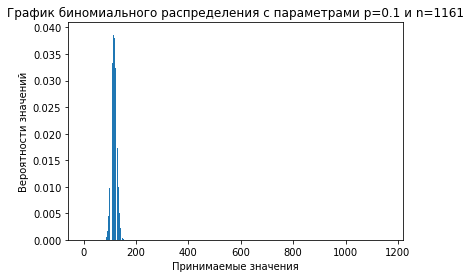

In [52]:
expected = 100
p = 0.1
alpha = 0.05
n_list = [1000 + i for i in range(1000)]
for n_curr in n_list:
    prob_less100 = 0
    for k in range(expected):
        prob_less100 += st.binom.pmf(k, n_curr, p)
    if prob_less100 < alpha:
        n = n_curr
        print('n =', n)
        print('P =', prob_less100)
        break
        
distr = []

for k in range(0, n + 1):
    prob = st.binom.pmf(k, n, p)
    distr.append(prob)

plt.bar(range(0, n+1), distr)
plt.title(f'График биномиального распределения с параметрами p={p} и n={n}')
plt.xlabel('Принимаемые значения')
plt.ylabel('Вероятности значений')
plt.show()

Вывод: необходимо разослать 1161 промокод

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вместо биномиального распределения можем использовать его аппроксимацию нормальным распределением. 

Мат ожидание = 400000.0
Стандартное отклонение = 489.89794855663564


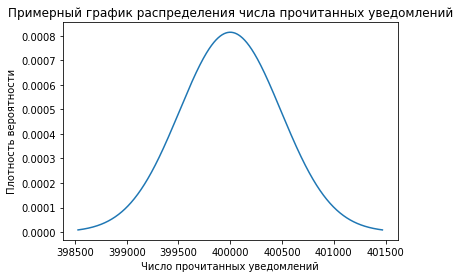

P = 0.15371708296369768210


In [53]:
p = 0.4
n = 1000000
threshold = 399500

print('Мат ожидание =', n*p)
print('Стандартное отклонение =', (n*p*(1-p))**0.5)

mu = n * p
sigma = (n*p*(1-p))**0.5

distr = st.norm(mu, sigma)

result = distr.cdf(threshold)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
cdf = distr.pdf(x)
plt.plot(x, cdf)
plt.title('Примерный график распределения числа прочитанных уведомлений')
plt.ylabel('Плотность вероятности')
plt.xlabel('Число прочитанных уведомлений')
plt.show()
print('P =', '{:.20f}'.format(result))

Выводы:
1. Были загружены 3 таблицы с данными об аренде самокатов - данные о пользователях, поездках и типах подписки.
2. Данные в загруженных таблицах были предобработаны: удалены дупликаты, столбцы преобразованы к наиболее подходящим типам, данные о длительности и дальности поездки были округлены до 2 знаков после запятой. 
3. Были исследованы следующие аспекты имеющихся данных: частота встречаемости городов, соотношение числа пользователей с подпиской и без нее, возраст пользователей, расстояние за одну поездку, продолжительность поездок. Были сделаны следующие выводы:
	- Данные о пользователях из 8 городов, доля пользователей из конкретного города изменяется от 11% до 14%
	- Без подписки приложением пользуются 54,4% пользователей, с подпиской - 45,6%.
	- Средний возраст пользователей равен 25 годам, минимальный - 12 лет, максимальный - 43 года. Законодательно минимальный возраст для пользования самокатом равен 14 годам (с учетом разрешения родителей), поэтому природа данных о пользователях младше 14 лет требуют дальнейшего изучения.
	- Расстояние поездки изменяется от 1 метра до 7211 метров со средним значением в 3070 метров. Распределение расстояний похоже на сумму двух нормальных распределений со средними, равными примерно 700 м (короткие поездки) и 3000 м (длинные поездки).
	- Продолжительность поездок изменяется в пределах от 30 секунд до 41 минуты со средним в 17,8 минут. По форме распределение близко к нормальному, но присутствует пик около нуля, соответствующий поездкам с продолжительностью в 30 секунд и средним расстоянием в 5113 метров, что говорит о неправильном подсчете длительности поездки.
4. Был создан объединенный датафрейм, содержащий помимо информации о поездке информацию о пользователе и данных о подписке. Далее были созданы отдельные таблицы с данными по пользователям без подписки и с подпиской. Длительность и расстояние поездок были визуализированы для данных о пользователях с подпиской и без, были сделаны следующий выводы:
	- Средние длительности и расстояния для разных типов подписки довольно близки (3045 м и 3115 м, 17,4 мин и 18,5 мин)
	- Пик, соответствующий поездкам с длительностью в 30 секунд характерен только для пользователей без подписки.
	- Два пика, соответствующие коротким и длинным поездкам, характерны для обоих типов подписки, но имеют немного разные максимумы (500 м и 2500 м без подписки, 1000 м и 3000 м с подпиской)
5. Для каждого пользователя были рассчитаны: суммарной расстояние, количество поездок и суммарное время за каждый месяц. При этом время в минутах было округлено до целого в большую сторону. На основании данных о подписке для каждого пользователя сначала была рассчитана стоимость каждой поездки, а затем траты за каждый из месяцев.
6. Проверялся ряд статистических гипотез для данных о пользователях с подпиской и без неё:
	- О равенстве среднего времени, затрачиваемого на поездки для пользователей с подпиской и без неё. Альтернатива - пользователи без подписки тратят больше времени в среднем. Приняли альтернативную гипотезу с p-значением, примерно равным 10^(-37).
	- О равенстве среднего расстояния у пользователей с подпиской числу 3130 метров. Альтернатива - среднее расстояние больше, чем 3130 метров. Гипотезу приняли с p-значением, равным 0.92.
	- О равенстве помесячной выручки от пользователей без подписки и с ней. Альтернатива - пользователи с подпиской в среднем приносят больше. Приняли альтернативную гипотезу с p-значением, порядка 10^(-40).
7. 

а) Была поставлена задача о вычислении числа промокодов, которые необходимо отправить, чтобы подписку продлили минимум 100 клиентов, при условии, что продлевают подписку в среднем 10% пользователей и вероятность не выполнить план была примерно 5%. Для этого распределение числа продленных подписок было описано биномиальным распределением, проверялись значения n от 1000 до 2000 при p=0.1. Оптимальным оказалось значение n=1161, для которого вероятность не выполнить план примерно равна 0.04976.

б) Рассматривалась задача о количестве push-уведомлений в мобильном приложении. Планировалось разослать 1 млн. уведомлений, которые открывают около 40% клиентов. Требовалось с помощью аппроксимации оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. Эта ситуация моделируется биномиальным распределением с параметрами n=1000000 и p=0.4. Биномиальное распределение аппроксимируем нормальным с теми же средним и стандартным отклонением. Оценка искомой вероятности оказалась примерно равной 0.154.
